In [14]:
def create_best_lstm_model(best_params):
    model = Sequential()
    n_layers = best_params['lstm_n_layers']
    units = best_params['lstm_units']
    for i in range(n_layers):
        model.add(LSTM(
            units=units,
            return_sequences=(i < n_layers - 1),
            input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]) if i == 0 else None
        ))
        model.add(Dropout(rate=best_params['lstm_dropout']))
    model.add(Dense(1))
    learning_rate = best_params['lstm_learning_rate']
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


def create_lstm_model(trial):
    model = Sequential()
    n_layers = trial.suggest_int('lstm_n_layers', 2, 4)  # Optimize number of LSTM layers
    units = trial.suggest_categorical('lstm_units', [50, 100, 150, 200])
    for i in range(n_layers):
        model.add(LSTM(
            units=units,
            return_sequences=(i < n_layers - 1),
            input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]) if i == 0 else None
        ))
        dropout_rate = trial.suggest_categorical('lstm_dropout', [0, 0.1, 0.2, 0.3, 0.4, 0.5])
        model.add(Dropout(rate=dropout_rate))  # Use specific dropout rate
    model.add(Dense(1))
    learning_rate = trial.suggest_categorical('lstm_learning_rate', [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001])  # Optimize learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Define optimization objective function
def objective_LSTM(trial):
    num_samples = X_train_lstm.shape[0] * 0.8
    batch_size_candidates = [16, 32, 64, 128, 256, 512, 1024, 2048]
    batch_size_candidates = [bs for bs in batch_size_candidates if bs <= num_samples]
    param = {
        'epochs': trial.suggest_categorical('lstm_epochs', [10, 20, 30, 40, 50, 75, 100, 150, 200]),
        'batch_size': trial.suggest_categorical('lstm_batch_size', batch_size_candidates)
    }
    param['batch_size'] = min(param['batch_size'], num_samples)  # Ensure batch_size does not exceed the number of samples in the training dataset
    model = KerasRegressor(build_fn=lambda: create_lstm_model(trial), epochs=param['epochs'], batch_size=param['batch_size'], verbose=0)
    
    # Use 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []
    
    for train_index, val_index in kf.split(X_train_lstm):
        X_train, X_val = X_train_lstm[train_index], X_train_lstm[val_index]
        y_train_fold, y_val = y_train[train_index], y_train[val_index]
        num_samples = X_train.shape[0]
        # 'patience' parameter defines how many epochs the model continues training without improvement before stopping
        # 'restore_best_weights' if True, the model's weights will be restored to the point with the lowest validation loss
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train_fold, validation_data=(X_val, y_val), callbacks=[early_stopping, KerasPruningCallback(trial, 'val_loss')])
        
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)
    
    return np.mean(mse_scores)


def plot_importance(df_importances, output_path, model_name, region, filename):
    """
    Plot bar chart and concentric pie chart of feature importance.

    Parameters:
        df_importances (DataFrame): Feature importance data, required to contain a 'feature' column.
        output_path (str): Base path for output files.
        model_name (str): Model name, used for folder structure and file naming.
        region (str): Region name, used for output file naming.
        filename (str): Full path of the output file (including name and extension).
    """
    # Categorize features
    # Feature-to-category mapping
    category_map = {
        'KNDVI': 'VI',          # Vegetation Index
        'EVI': 'VI',            # Vegetation Index
        'NDVI': 'VI',           # Vegetation Index
        'modis_Gpp': 'VI',      # Vegetation Index (Gross Primary Productivity)
        'Fpar': 'VI',           # Vegetation Index (Fraction of Photosynthetically Active Radiation)
        'modis_LAI': 'VI',      # Vegetation Index (Leaf Area Index)
        'PML_Gpp': 'VI',        # Vegetation Index (Gross Primary Productivity from PML model)
        'Mean_Yield': 'TI',     # Temporal Index (Long-term average yield)
        'Previous_Yield': 'TI', # Temporal Index (Previous year's yield)
        'year': 'TI',           # Temporal Index (Year as a temporal feature)
        'Pre': 'MC',            # Meteorological Conditions (Precipitation)
        'Tmin': 'MC',           # Meteorological Conditions (Minimum Temperature)
        'Solar': 'MC',          # Meteorological Conditions (Solar Radiation)
        'Tmean': 'MC',          # Meteorological Conditions (Mean Temperature)
        'Tmax': 'MC',           # Meteorological Conditions (Maximum Temperature)
        'CDD': 'EC',            # Extreme Climate (Cooling Degree Days)
        'HDD': 'EC',            # Extreme Climate (Heating Degree Days)
        'GDD': 'EC',            # Extreme Climate (Growing Degree Days)
        'VPD': 'EC',            # Extreme Climate (Vapor Pressure Deficit)
        'SPEI': 'EC',           # Extreme Climate (Standardized Precipitation-Evapotranspiration Index)
        'wind_speed': 'EC',     # Extreme Climate (Wind Speed)
        'SAND': 'CEC',          # Climatic and Edaphic Conditions (Soil sand content)
        'AWC': 'CEC',           # Climatic and Edaphic Conditions (Available Water Capacity)
        'SILT': 'CEC',          # Climatic and Edaphic Conditions (Soil silt content)
        'ORG_CARBON': 'CEC',    # Climatic and Edaphic Conditions (Soil organic carbon)
        'TOTAL_N': 'CEC',       # Climatic and Edaphic Conditions (Total soil nitrogen)
        'PH_WATER': 'CEC',      # Climatic and Edaphic Conditions (Soil pH in water)
        'CEC_SOIL': 'CEC',      # Climatic and Edaphic Conditions (Cation Exchange Capacity)
        'CLAY': 'CEC',          # Climatic and Edaphic Conditions (Soil clay content)
        'elevation': 'CEC',     # Climatic and Edaphic Conditions (Elevation)
        'lat': 'CEC',           # Climatic and Edaphic Conditions (Latitude)
        'lon': 'CEC'            # Climatic and Edaphic Conditions (Longitude)
    }
    # Set file save path
    folder_path = os.path.join(output_path, '06_figure', 'results', model_name)
    os.makedirs(folder_path, exist_ok=True)

    # Calculate mean feature contribution
    df_importances_mean = df_importances.mean(axis=1).reset_index()
    df_importances_mean['Category'] = df_importances_mean['feature'].map(category_map)
    df_importances_mean = df_importances_mean[['feature', 0, 'Category']]
    df_importances_mean.columns = ['Feature', 'Contribution', 'Category']

    # Exclude baseline feature and sort by category and contribution
    contribution_df_sorted = df_importances_mean[df_importances_mean['Feature'] != 'BASELINE']
    contribution_df_sorted = contribution_df_sorted.sort_values(by=['Category', 'Contribution'], ascending=[True, False])

    # Define category colors and gradient function
    category_colors = {
        'VI': (0.9, 0.7, 0.2, 1),  # Yellow
        'TI': (0.6, 0.3, 0.9, 1),  # Purple
        'MC': (0.7, 0.3, 0.3, 1),  # Dark red
        'EC': (0.2, 0.9, 0.9, 1),  # Cyan
        'CEC': (0.3, 0.6, 0.9, 1)  # Light blue
    }
    default_color = (0.8, 0.8, 0.8, 1)  # Gray

    def get_color_gradient(base_color, num_shades):
        gradient = np.linspace(0.4, 1, num_shades)
        return [(base_color[0], base_color[1], base_color[2], shade) for shade in gradient]

    # Inner and outer circle data for pie chart
    inner_contribution = contribution_df_sorted.groupby('Category')['Contribution'].sum()
    outer_contribution = contribution_df_sorted.set_index('Feature')['Contribution']

    # Create color gradient for outer circle
    outer_colors = []
    for category in inner_contribution.index:
        category_df = contribution_df_sorted[contribution_df_sorted['Category'] == category]
        base_color = category_colors.get(category, default_color)
        gradient_colors = get_color_gradient(base_color, len(category_df))
        outer_colors.extend(gradient_colors)

    # Plot figure
    fig, ax = plt.subplots(figsize=(10, 8), dpi=1200)
    ax.set_facecolor('#f0f0f0')
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)

    # Plot horizontal bar chart (sorted by contribution descending)
    contribution_df_sorted = contribution_df_sorted.sort_values(by='Contribution', ascending=False)
    bar_colors = [category_colors.get(cat, default_color) for cat in contribution_df_sorted['Category']]
    ax.barh(contribution_df_sorted['Feature'], contribution_df_sorted['Contribution'], color=bar_colors)
    ax.set_xlabel('Contribution')
    ax.set_ylabel('Feature')
    ax.set_title('Feature Contributions by Category')
    ax.invert_yaxis()  # Invert y-axis to display top contributors at the top

    # Add legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[cat]) for cat in category_colors]
    ax.legend(handles, category_colors.keys(), loc='lower right')

    # Embed concentric pie chart
    inset_ax = inset_axes(ax, width=2, height=2, loc='upper right', bbox_to_anchor=(0.8, 0.35, 0.2, 0.2), bbox_transform=ax.transAxes)
    # Inner pie chart (category-level contribution)
    inset_ax.pie(inner_contribution, labels=[''] * len(inner_contribution), autopct='%1.1f%%', radius=1,
                 colors=[category_colors.get(cat, default_color) for cat in inner_contribution.index], wedgeprops=dict(width=0.3, edgecolor='w'))
    # Outer pie chart (feature-level contribution)
    inset_ax.pie(outer_contribution, labels=[''] * len(outer_contribution), radius=0.7, colors=outer_colors, wedgeprops=dict(width=0.3, edgecolor='w'))
    # Add white center circle
    inset_ax.add_artist(plt.Circle((0, 0), 0.4, color='white'))

    # Save figure (TIFF format for high-quality academic use)
    plt.savefig(filename, format='tiff', bbox_inches='tight')
    plt.show()

def plt_scatter(data, filename):
    dataframes = data[['predicts', 'records']]
    r2 = r2_score(dataframes['records'], dataframes['predicts'])
    # Calculate NRMSE (Normalized Root Mean Square Error)
    mse = mean_squared_error(dataframes['records'], dataframes['predicts'])
    nrmse = np.sqrt(mse) / np.mean(dataframes['records'])
    rrmse = calculate_rrmse1(dataframes['records'], dataframes['predicts'])
    
    mape = mean_absolute_percentage_error(dataframes['records'], dataframes['predicts'])
    acc = calculate_acc(dataframes['records'], dataframes['predicts'])
    
    # Create scatter plot with hexbin density
    plt.figure(figsize=(10, 6))
    plt.hexbin(dataframes['records'], dataframes['predicts'], gridsize=50, cmap='viridis', mincnt=1)
    cb = plt.colorbar(label='Density')  # Color bar for density visualization
    
    # Add linear fit line
    fit_params = np.polyfit(dataframes['records'], dataframes['predicts'], 1)
    fit_line = np.polyval(fit_params, dataframes['records'])
    plt.plot(dataframes['records'], fit_line, color='red', label='Fit line')
    
    # Add 1:1 reference line
    max_val = max(max(dataframes['records']), max(dataframes['predicts']))
    plt.plot([0, max_val], [0, max_val], linestyle='--', color='green', label='1:1 line')
    
    # Set plot labels and layout
    plt.title('')
    plt.xlabel('Observed values')
    plt.ylabel('Predicted values')
    plt.grid(True)
    
    # Add evaluation metrics text
    plt.text(0.02, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes, fontsize=12, va='top')
    plt.text(0.02, 0.90, f'ACC = {acc:.2f}', transform=plt.gca().transAxes, fontsize=12, va='top')
    plt.text(0.02, 0.85, f'RRMSE = {rrmse:.2f}%', transform=plt.gca().transAxes, fontsize=12, va='top')
    plt.text(0.02, 0.80, f'MAPE = {mape*100:.2f}%', transform=plt.gca().transAxes, fontsize=12, va='top')
    
    # Save and display figure
    plt.savefig(filename)
    plt.show()

def calculate_rrmse2(y_true, y_pred):
    """
    Calculate rRMSE (Relative Root Mean Square Error) using each individual actual value as reference.
    
    Parameters:
    y_true -- Array or list of true values
    y_pred -- Array or list of predicted values
    
    Returns:
    rrmse -- Relative Root Mean Square Error (percentage)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate rRMSE
    rrmse = np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2)) * 100
    
    return rrmse

# Define custom nRMSE evaluation function
def calculate_nrmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    nrmse = rmse / (y_true.max() - y_true.min())
    return nrmse * 100

def calculate_acc(y_true, y_pred):
    # Calculate means of observed and predicted values
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    
    # Calculate anomalies (deviations from the mean)
    anomaly_true = y_true - mean_true
    anomaly_pred = y_pred - mean_pred
    
    # Calculate ACC (Anomaly Correlation Coefficient)
    numerator = np.sum(anomaly_true * anomaly_pred)
    denominator = np.sqrt(np.sum(anomaly_true**2) * np.sum(anomaly_pred**2))
    
    acc = numerator / denominator
    return acc

def extract_selected_variables(inputpath_base):
    inpath_dates = os.path.join(inputpath_base, 'dataset', "01_inputdata", 'selectFeatures.txt')
    # Construct file path
    gs_infornamtion = pd.read_csv(inpath_dates, sep='\t', header=None)
    gs_infornamtion.columns = ['slected_dynamic_features', 'slected_static', 'regionID']
    gs_infornamtion['slected_dynamic_features'] = gs_infornamtion['slected_dynamic_features'].apply(ast.literal_eval)
    gs_infornamtion['slected_static'] = gs_infornamtion['slected_static'].apply(ast.literal_eval)
    return gs_infornamtion

def calculate_rrmse1(y_true, y_pred):
    """
    Calculate RRMSE (Relative Root Mean Square Error) using the mean of actual values as reference.
    
    Parameters:
    y_true -- Array or list of true values
    y_pred -- Array or list of predicted values
    
    Returns:
    rrmse -- Relative Root Mean Square Error (percentage)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    # Calculate mean of true values
    mean_y_true = np.mean(y_true)
    
    # Calculate RRMSE
    rrmse = (rmse / mean_y_true) * 100
    
    return rrmse

In [4]:
import os
import sys
import ast
sys.path.append(r'C:\ProgramData\anaconda3\Lib\site-packages') 
sys.path.append(r'C:\Users\DELL\.conda\envs\myenv\Lib\site-packages') 
sys.path.append(r'C:\Users\DELL\.conda\envs\rasterio_env\Lib\site-packages') 
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


import optuna
from optuna_integration.keras import KerasPruningCallback
from optuna.samplers import TPESampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_percentage_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.model_selection import train_test_split

countryID = '06_India';
country =countryID[3:]
crop = '02_wheat';yield_type= 'actual_yield';

inputpath_base = os.path.dirname(os.getcwd())
startyear = 2001;endyear = 2018
Forecastyear = endyear
region = 'I'
Forecastyears = {
    'I': Forecastyear}
years = range(startyear,endyear+1)
years_str = [str(year) for year in years]
modelname = 'LSTM'
yield_type = 'actual_yield';
SelFeature_infornamtion = extract_selected_variables(inputpath_base)
institution = 'ECMWF';

inpath_dates = os.path.join(inputpath_base, 'dataset',"01_inputdata",'gs_three_periods.txt')
gs_infornamtion = pd.read_csv(inpath_dates, delim_whitespace=True, header=None)
gs_infornamtion.columns = ['start_point', 'peak', 'harvest_point', 'VI_select2','regionID']
start_point, peak, harvest_point, VI_select2, region = gs_infornamtion[gs_infornamtion['regionID'] == region].iloc[0]

In [8]:
##################################Integrate Historical Forecast Dataset#############################################################
###################Load Selected Feature Variables#########################################
Forecastyear = Forecastyears[region]  # Get forecast year for the target region
# Load original dataset
data = pd.read_csv(os.path.join(inputpath_base, 'dataset', "01_inputdata", region + '_data_ori.csv'))

# Extract selected dynamic features, static features, and region ID
TimeFeatures_sel, Static_sel, regionID = SelFeature_infornamtion[SelFeature_infornamtion['regionID'] == region].iloc[0]
feature_all = TimeFeatures_sel + Static_sel  # Combine dynamic and static features into a complete feature list
# Filter columns containing any of the selected features
filtered_columns = [col for col in data.columns if any(feature in col for feature in feature_all)]


####Exclude yield-related features if present#########################
filtered_columns = [col for col in filtered_columns if 'Yield' not in col]  # Exclude yield-related features to avoid correlation bias
Static_sel = [col for col in Static_sel if 'Yield' not in col]  # Update static features (remove yield-related items)
feature_all = [col for col in feature_all if 'Yield' not in col]  # Update complete feature list (remove yield-related items)
#############################################################

# Construct machine learning dataset (selected features + target yield)
MLdata_reduced = data[filtered_columns + [yield_type]]
MLdata_reduced['year'] = data['year']  # Add year column back to the dataset

############################Data Standardization###########################################################
data_all = MLdata_reduced  # Full dataset for modeling
X_all = data_all.drop([yield_type], axis=1)  # Feature matrix (exclude target variable)
y_all = data_all[yield_type]  # Target variable (yield)

# Standardize feature matrix and target variable (fit scaler on full original dataset)
scaler_X = StandardScaler().fit(X_all)
X = scaler_X.transform(X_all)
scaler_y = StandardScaler().fit(y_all.values.reshape(-1, 1))
y = scaler_y.transform(y_all.values.reshape(-1, 1)).flatten()

# Load pre-trained LSTM model
outpathmodel = os.path.join(inputpath_base, 'Trained model')
model_path = os.path.join(outpathmodel, region + 'my_lstm_model.keras')
model = load_model(model_path)

###################################################Process Historical Dataset###################################################
# Get list of historical forecast period folders (e.g., different forecast dates)
hisDataList = os.listdir(os.path.join(inputpath_base, 'dataset', '02_ForecastData', 'Hist', region))
dataframe_his_0913 = pd.DataFrame()  # Store all historical forecast results

# Generate list of growth stage weeks (handle cross-year growth periods)
if start_point > harvest_point:
    # Cross-year growth period: combine weeks from start_point to 46 and 1 to harvest_point
    weeks_select_list = list(range(start_point, 47)) + list(range(1, harvest_point + 1))
else:
    # Same-year growth period: direct range from start_point to harvest_point
    weeks_select_list = list(range(start_point, harvest_point + 1))

# Iterate over each forecast period folder
for ii in hisDataList:
    # Path to historical forecast data for the current period
    inputpath_his = os.path.join(inputpath_base, 'dataset', '02_ForecastData', 'Hist', region, ii)
    # Output path for historical forecast results (preserve folder structure)
    outpath_his = os.path.join(inputpath_base, 'results', 'Forecast', 'Hist', region, ii)
    os.makedirs(outpath_his, exist_ok=True)  # Create directory if it doesn't exist
    
    # Process historical data of the past 30 years for each forecast period
    for year_his in range(Forecastyear - 30, Forecastyear):
        # Load historical data for the specific year
        data_his_new = pd.read_csv(os.path.join(inputpath_his, 'hist_' + str(year_his) + '.csv'))
        # Inner join with original data to retain valid (year, idJoin) pairs (ensure consistency)
        data_his_new = data_his_new.merge(data[['year', 'idJoin']], on=['year', 'idJoin'], how='inner')
        
        # Prepare forecast dataset (selected features + target yield)
        Forecast_his = data_his_new[filtered_columns + [yield_type]]
        Forecast_his['year'] = Forecastyear  # Label with the target forecast year
        # Split into features and target variable
        X_test = Forecast_his.drop([yield_type], axis=1)
        y_test = Forecast_his[yield_type]
        
        # Apply standardization (use scaler fitted on original dataset)
        X_test = scaler_X.transform(X_test)
        y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
        
        # Reshape test data into 3D format (samples, time steps, features) required for LSTM
        data_list = []
        X_test = pd.DataFrame(data=X_test, columns=X_all.columns.tolist())
        for i in weeks_select_list:
            # Extract features for the i-th week (dynamic features + static features)
            data_i = X_test[[f'Week{i}_{feature}' for feature in TimeFeatures_sel] + Static_sel]
            data_list.append(data_i.values)
        
        # Stack and transpose to (samples, time steps, features)
        data_list = np.array(data_list)
        X_test_lstm = np.transpose(data_list, (1, 0, 2))
        
        # Generate predictions using the pre-trained model
        y_pred = model.predict(X_test_lstm)
        # Inverse transform to convert standardized values back to original yield scale
        y_pred_inverse = scaler_y.inverse_transform(y_pred)
        y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))
        
        # Create DataFrame to store prediction results for the current historical year
        data_pre = pd.DataFrame({
            'predicts': y_pred_inverse.ravel(),
            'records': y_test_inverse.ravel()
        })
        # Add metadata: target forecast year, region ID, historical data year, forecast period
        data_pre['year'] = Forecastyear
        data_pre['idJoin'] = data_his_new['idJoin'].values
        data_pre['hist'] = year_his
        data_pre['forecastData'] = ii
        
        # Save results for the current historical year and forecast period
        data_pre.to_csv(os.path.join(outpath_his, 'his_' + str(Forecastyear) + '_' + str(year_his) + '.csv'), index=False)
        # Concatenate to the full historical results DataFrame
        dataframe_his_0913 = pd.concat([dataframe_his_0913, data_pre], axis=0)

# Save all historical forecast results to a single CSV file
dataframe_his_0913.to_csv(os.path.join(outpath_his, str(Forecastyear) + 'his.csv'), index=False)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


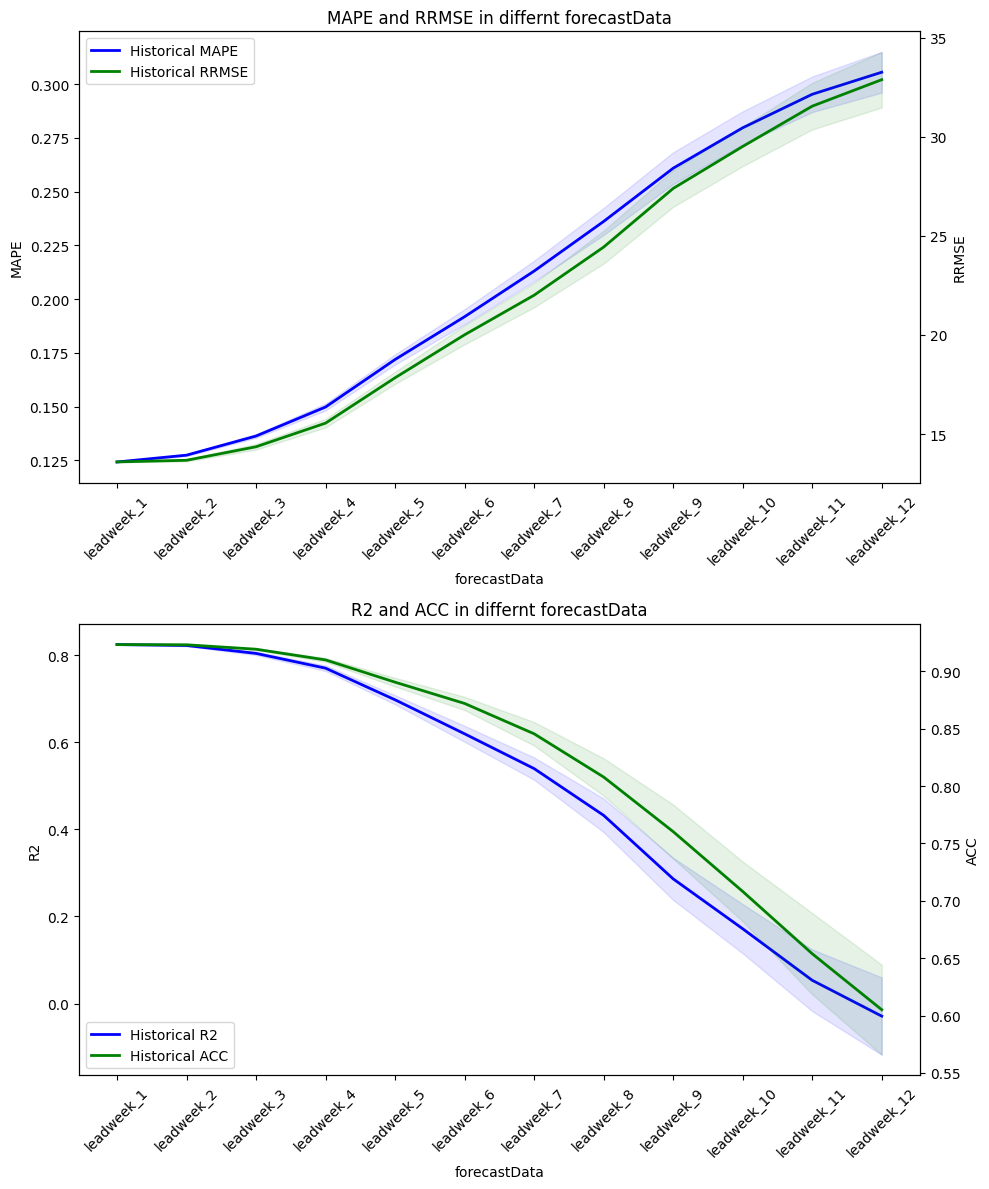

In [15]:
region = 'I'  # Target region identifier
# Aggregate data across all historical years
dataframe_his_0913 = pd.read_csv(os.path.join(outpath_his, str(Forecastyear) + 'his.csv'))

# Define columns related to evaluation metrics and grouping
metrics_his = ['predicts', 'records', 'year', 'forecastData', 'hist']
# Group data by forecast period (forecastData) and historical year (hist)
grouped_his = dataframe_his_0913[metrics_his].groupby(['forecastData', 'hist'])

# Calculate evaluation metrics for each group
# 1. MAPE (Mean Absolute Percentage Error)
mape_values_his = grouped_his.apply(
    lambda group: mean_absolute_percentage_error(group['records'], group['predicts'])
).reset_index(name='MAPE')

# 2. ACC (Anomaly Correlation Coefficient)
ACC_values_his = grouped_his.apply(
    lambda group: calculate_acc(group['records'], group['predicts'])
).reset_index(name='ACC')

# 3. R² (Coefficient of Determination)
r2_values_his = grouped_his.apply(
    lambda group: r2_score(group['records'], group['predicts'])
).reset_index(name='R2')

# 4. RRMSE (Relative Root Mean Square Error, reference: mean of true values)
rrmse_values_his = grouped_his.apply(
    lambda group: calculate_rrmse1(group['records'], group['predicts'])
).reset_index(name='RRMSE')

# Merge all metric results into a single DataFrame (using forecastData and hist as keys)
accuracy_his = mape_values_his.merge(ACC_values_his, on=['forecastData', 'hist']) \
                              .merge(r2_values_his, on=['forecastData', 'hist']) \
                              .merge(rrmse_values_his, on=['forecastData', 'hist'])

# Extract week number from forecastData (assume forecastData format: xxx_weekN, e.g., "forecast_0913" → 913)
accuracy_his['week'] = accuracy_his['forecastData'].apply(lambda x: int(x.split('_')[-1]))
# Sort by week number and remove the temporary 'week' column
accuracy_his = accuracy_his.sort_values(by='week').drop(columns='week')

# Validate required columns to ensure data integrity
required_columns = ['RRMSE', 'MAPE', 'R2', 'ACC', 'forecastData']
for df, name in zip([accuracy_his], ['accuracy_his']):
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"{name} DataFrame must contain the following columns: {required_columns}")

# Group by forecastData and calculate mean and standard deviation for each metric
grouped_his = accuracy_his[['MAPE', 'ACC', 'R2', 'RRMSE', 'forecastData']].groupby('forecastData').agg(['mean', 'std'])
# Reorder columns to follow [RRMSE, MAPE, R2, ACC] for consistency
grouped_his = grouped_his[['RRMSE', 'MAPE', 'R2', 'ACC']]

# Extract week number from forecastData index for sorting (replicate previous logic)
grouped_his['week'] = [int(x.split('_')[-1]) for x in grouped_his.index]
# Sort by week number and drop the temporary 'week' column
grouped_his = grouped_his.sort_values(by='week').drop(columns='week')

# Plot evaluation metrics across different forecast periods
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))  # 2 rows, 1 column of subplots

# ----------- First Subplot: MAPE and RRMSE (Dual Y-axes) -----------
# Plot MAPE (mean ± std)
ax1.plot(grouped_his.index, grouped_his['MAPE']['mean'], color='blue', label='Historical MAPE', linewidth=2)
ax1.fill_between(
    grouped_his.index,
    grouped_his['MAPE']['mean'] - grouped_his['MAPE']['std'],
    grouped_his['MAPE']['mean'] + grouped_his['MAPE']['std'],
    alpha=0.1, color='blue', label='MAPE Std'
)
ax1.set_ylabel('MAPE')
ax1.set_title('MAPE and RRMSE Across Different Forecast Periods')
ax1.set_xlabel('Forecast Period (forecastData)')
ax1.tick_params(axis='x', rotation=45)  # Rotate x-labels to avoid overlap
ax1.grid(True, alpha=0.3)

# Create dual y-axis for RRMSE (shared x-axis)
ax1_twin = ax1.twinx()
ax1_twin.plot(grouped_his.index, grouped_his['RRMSE']['mean'], color='green', label='Historical RRMSE', linewidth=2)
ax1_twin.fill_between(
    grouped_his.index,
    grouped_his['RRMSE']['mean'] - grouped_his['RRMSE']['std'],
    grouped_his['RRMSE']['mean'] + grouped_his['RRMSE']['std'],
    alpha=0.1, color='green', label='RRMSE Std'
)
ax1_twin.set_ylabel('RRMSE (%)')

# Merge legends from both y-axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

# ----------- Second Subplot: R² and ACC (Dual Y-axes) -----------
# Plot R² (mean ± std)
ax2.plot(grouped_his.index, grouped_his['R2']['mean'], color='blue', label='Historical R²', linewidth=2)
ax2.fill_between(
    grouped_his.index,
    grouped_his['R2']['mean'] - grouped_his['R2']['std'],
    grouped_his['R2']['mean'] + grouped_his['R2']['std'],
    alpha=0.1, color='blue', label='R² Std'
)
ax2.set_ylabel('R²')
ax2.set_title('R² and ACC Across Different Forecast Periods')
ax2.set_xlabel('Forecast Period (forecastData)')
ax2.tick_params(axis='x', rotation=45)  # Rotate x-labels to avoid overlap
ax2.grid(True, alpha=0.3)

# Create dual y-axis for ACC (shared x-axis)
ax2_twin = ax2.twinx()
ax2_twin.plot(grouped_his.index, grouped_his['ACC']['mean'], color='green', label='Historical ACC', linewidth=2)
ax2_twin.fill_between(
    grouped_his.index,
    grouped_his['ACC']['mean'] - grouped_his['ACC']['std'],
    grouped_his['ACC']['mean'] + grouped_his['ACC']['std'],
    alpha=0.1, color='green', label='ACC Std'
)
ax2_twin.set_ylabel('ACC')

# Merge legends from both y-axes
handles3, labels3 = ax2.get_legend_handles_labels()
handles4, labels4 = ax2_twin.get_legend_handles_labels()
ax2.legend(handles3 + handles4, labels3 + labels4, loc='lower left')

# Automatically adjust layout to prevent label overlap
plt.tight_layout()

# Save plot to specified directory
folder_path = os.path.join(inputpath_base, 'figure', modelname)
os.makedirs(folder_path, exist_ok=True)
filename = os.path.join(folder_path, f'historical_forecast_metrics_{region}_{Forecastyear}.tiff')
plt.savefig(filename, format='tiff', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

In [19]:
accuracy_his.to_csv(os.path.join(outpath_his,str(Forecastyear)+'Hist_accuracy.csv'),index=False)

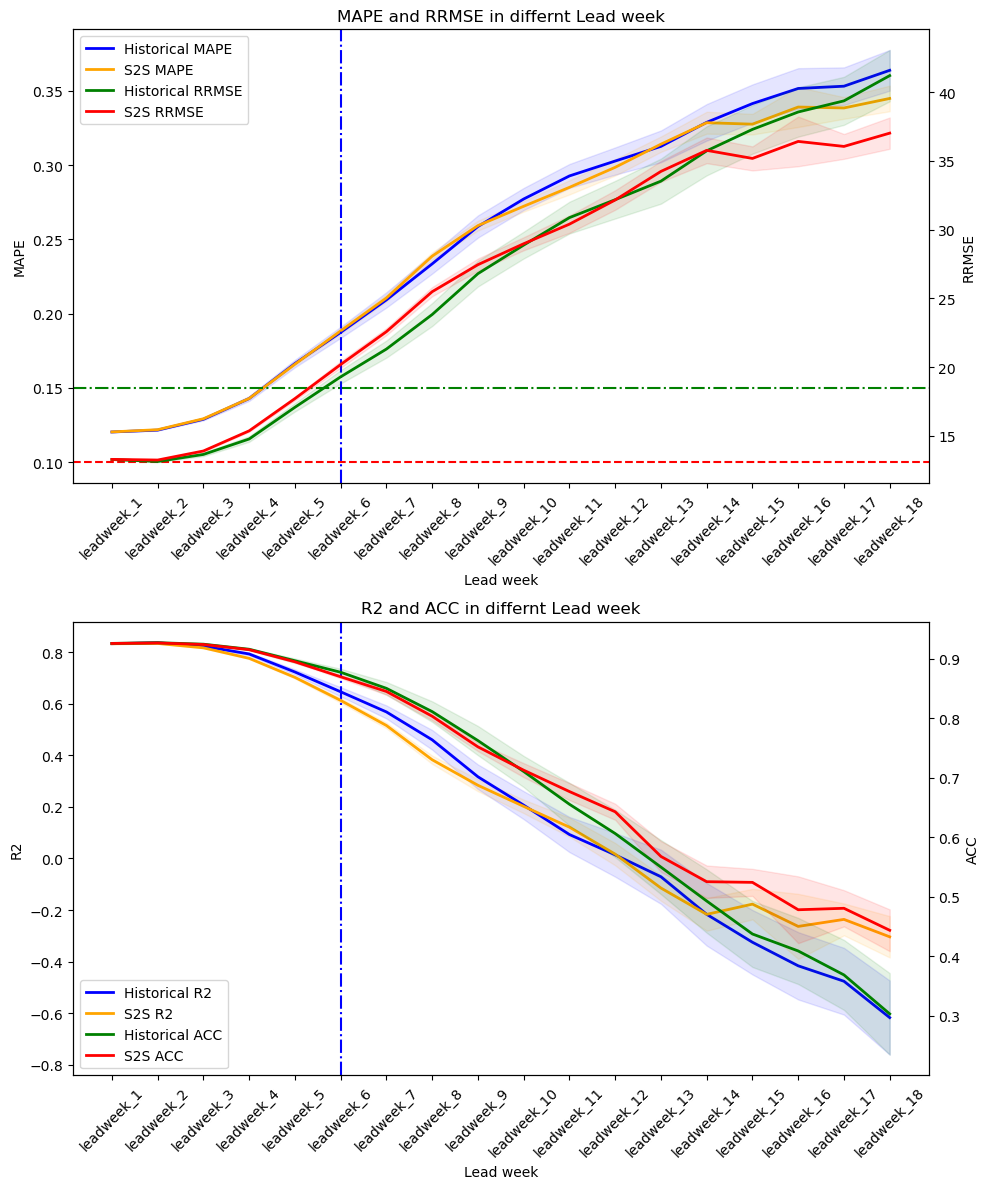

In [16]:
def plot_compare_S2S_hist_week(accuracy_his, accuracy_S2S, filename=None):
    """
    Compare four accuracy metrics (RRMSE, MAPE, R², ACC) between historical data and S2S data across different Lead Weeks.

    Parameters:
    - accuracy_his: pandas DataFrame, contains historical data. Must include the following columns: ['RRMSE', 'MAPE', 'R2', 'ACC', 'Lead week']
    - accuracy_S2S: pandas DataFrame, contains S2S (Subseasonal-to-Seasonal) data. Must include the following columns: ['RRMSE', 'MAPE', 'R2', 'ACC', 'Lead week']
    - filename: str, optional. Full path to save the plot (e.g., 'compare_S2S_hist_metrics.tiff'). If None, plot is not saved.
    
    Example:
    plot_compare_S2S_hist_week(accuracy_his_df, accuracy_S2S_df, filename='compare_metrics_2025.tiff')
    """
    
    # Ensure 'Lead week' column exists in both DataFrames
    required_columns = ['RRMSE', 'MAPE', 'R2', 'ACC', 'Lead week']
    for df, name in zip([accuracy_his, accuracy_S2S], ['accuracy_his', 'accuracy_S2S']):
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"{name} DataFrame must contain the following columns: {required_columns}")
    
    # Group by 'Lead week' and calculate mean + standard deviation for each metric
    grouped_his = accuracy_his[['MAPE', 'ACC', 'R2', 'RRMSE', 'Lead week']].groupby('Lead week').agg(['mean', 'std'])
    grouped_S2S = accuracy_S2S[['MAPE', 'ACC', 'R2', 'RRMSE', 'Lead week']].groupby('Lead week').agg(['mean', 'std'])
    
    # Reorder columns to maintain consistency: [RRMSE, MAPE, R2, ACC]
    metric_order = ['RRMSE', 'MAPE', 'R2', 'ACC']
    grouped_his = grouped_his[metric_order]
    grouped_S2S = grouped_S2S[metric_order]
    
    # Ensure Lead weeks are sorted in ascending order (convert index to categorical if needed)
    grouped_his = grouped_his.sort_index()
    grouped_S2S = grouped_S2S.sort_index()
    
    # Create 2-row, 1-column subplot layout
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # ----------- First Subplot: MAPE and RRMSE (Dual Y-axes) -----------
    # Plot Historical MAPE (mean ± std)
    ax1.plot(grouped_his.index, grouped_his['MAPE']['mean'], color='blue', label='Historical MAPE', linewidth=2)
    ax1.fill_between(
        grouped_his.index,
        grouped_his['MAPE']['mean'] - grouped_his['MAPE']['std'],
        grouped_his['MAPE']['mean'] + grouped_his['MAPE']['std'],
        alpha=0.1, color='blue', label='Historical MAPE Std'
    )
    
    # Plot S2S MAPE (mean ± std)
    ax1.plot(grouped_S2S.index, grouped_S2S['MAPE']['mean'], color='orange', label='S2S MAPE', linewidth=2)
    ax1.fill_between(
        grouped_S2S.index,
        grouped_S2S['MAPE']['mean'] - grouped_S2S['MAPE']['std'],
        grouped_S2S['MAPE']['mean'] + grouped_S2S['MAPE']['std'],
        alpha=0.1, color='orange', label='S2S MAPE Std'
    )
    
    # Add reference lines (interpretation: common accuracy thresholds)
    ax1.axhline(y=0.1, color='r', linestyle='--', label='MAPE Threshold (0.1)')  # Red dashed line: Strict accuracy threshold
    ax1.axhline(y=0.15, color='g', linestyle='-.', label='MAPE Threshold (0.15)')  # Green dash-dot line: Relaxed accuracy threshold
    ax1.axvline(x='leadweek_6', color='b', linestyle='-.', label='Key Lead Week (6)')  # Blue dash-dot line: Critical lead week
    
    ax1.set_ylabel('MAPE')
    ax1.set_title('MAPE and RRMSE Across Different Lead Weeks')
    ax1.set_xlabel('Lead Week')
    ax1.tick_params(axis='x', rotation=45)  # Rotate x-labels to avoid overlap
    ax1.grid(True, alpha=0.3)
    
    # Dual Y-axis for RRMSE
    ax1_twin = ax1.twinx()
    # Plot Historical RRMSE (mean ± std)
    ax1_twin.plot(grouped_his.index, grouped_his['RRMSE']['mean'], color='green', label='Historical RRMSE', linewidth=2)
    ax1_twin.fill_between(
        grouped_his.index,
        grouped_his['RRMSE']['mean'] - grouped_his['RRMSE']['std'],
        grouped_his['RRMSE']['mean'] + grouped_his['RRMSE']['std'],
        alpha=0.1, color='green', label='Historical RRMSE Std'
    )
    
    # Plot S2S RRMSE (mean ± std)
    ax1_twin.plot(grouped_S2S.index, grouped_S2S['RRMSE']['mean'], color='red', label='S2S RRMSE', linewidth=2)
    ax1_twin.fill_between(
        grouped_S2S.index,
        grouped_S2S['RRMSE']['mean'] - grouped_S2S['RRMSE']['std'],
        grouped_S2S['RRMSE']['mean'] + grouped_S2S['RRMSE']['std'],
        alpha=0.1, color='red', label='S2S RRMSE Std'
    )
    
    ax1_twin.set_ylabel('RRMSE (%)')
    
    # Merge legends from both Y-axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0, 1))
    
    # ----------- Second Subplot: R² and ACC (Dual Y-axes) -----------
    # Plot Historical R² (mean ± std)
    ax2.plot(grouped_his.index, grouped_his['R2']['mean'], color='blue', label='Historical R²', linewidth=2)
    ax2.fill_between(
        grouped_his.index,
        grouped_his['R2']['mean'] - grouped_his['R2']['std'],
        grouped_his['R2']['mean'] + grouped_his['R2']['std'],
        alpha=0.1, color='blue', label='Historical R² Std'
    )
    
    # Plot S2S R² (mean ± std)
    ax2.plot(grouped_S2S.index, grouped_S2S['R2']['mean'], color='orange', label='S2S R²', linewidth=2)
    ax2.fill_between(
        grouped_S2S.index,
        grouped_S2S['R2']['mean'] - grouped_S2S['R2']['std'],
        grouped_S2S['R2']['mean'] + grouped_S2S['R2']['std'],
        alpha=0.1, color='orange', label='S2S R² Std'
    )
    
    # Add critical lead week reference line (consistent with first subplot)
    ax2.axvline(x='leadweek_6', color='b', linestyle='-.', label='Key Lead Week (6)')
    
    ax2.set_ylabel('R²')
    ax2.set_title('R² and ACC Across Different Lead Weeks')
    ax2.set_xlabel('Lead Week')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Dual Y-axis for ACC
    ax2_twin = ax2.twinx()
    # Plot Historical ACC (mean ± std)
    ax2_twin.plot(grouped_his.index, grouped_his['ACC']['mean'], color='green', label='Historical ACC', linewidth=2)
    ax2_twin.fill_between(
        grouped_his.index,
        grouped_his['ACC']['mean'] - grouped_his['ACC']['std'],
        grouped_his['ACC']['mean'] + grouped_his['ACC']['std'],
        alpha=0.1, color='green', label='Historical ACC Std'
    )
    
    # Plot S2S ACC (mean ± std)
    ax2_twin.plot(grouped_S2S.index, grouped_S2S['ACC']['mean'], color='red', label='S2S ACC', linewidth=2)
    ax2_twin.fill_between(
        grouped_S2S.index,
        grouped_S2S['ACC']['mean'] - grouped_S2S['ACC']['std'],
        grouped_S2S['ACC']['mean'] + grouped_S2S['ACC']['std'],
        alpha=0.1, color='red', label='S2S ACC Std'
    )
    
    ax2_twin.set_ylabel('ACC')
    
    # Merge legends from both Y-axes
    handles3, labels3 = ax2.get_legend_handles_labels()
    handles4, labels4 = ax2_twin.get_legend_handles_labels()
    ax2.legend(handles3 + handles4, labels3 + labels4, loc='lower left', bbox_to_anchor=(0, 0))
    
    # Automatically adjust layout to prevent label overlap
    plt.tight_layout()
    
    # Save plot if filename is provided (high-resolution TIFF for academic use)
    if filename:
        folder_path = os.path.dirname(filename)
        if folder_path:
            os.makedirs(folder_path, exist_ok=True)
        plt.savefig(filename, format='tiff', bbox_inches='tight', dpi=300)
    
    # Display the plot
    plt.show()

# Create copies of DataFrames to avoid modifying original data
accuracy_S2S1 = accuracy_S2S.copy()
accuracy_his1 = accuracy_his.copy()

# Rename 'forecastData' to 'Lead week' to match function requirements
accuracy_S2S1.rename(columns={'forecastData': 'Lead week'}, inplace=True)
accuracy_his1.rename(columns={'forecastData': 'Lead week'}, inplace=True)

# Call the comparison plot function
plot_compare_S2S_hist_week(accuracy_his1, accuracy_S2S1)

In [ ]:
# Hyperparameter Optimization
'''
# Define storage path and study name (SQLite database to persist optimization results)
storage_name = f"sqlite:///{country}_{country}_{modelname}_region{region}_1007.db"
study_name = f"{country}_{modelname}_region{region}_1007"

# Create Optuna study:
# - direction='minimize': Minimize validation MSE
# - sampler=TPESampler(): Use Tree-structured Parzen Estimator (state-of-the-art for hyperparameter optimization)
# - load_if_exists=True: Load existing study if it was previously created (avoids re-running trials)
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(),
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True
)

# Run hyperparameter optimization:
# - n_trials=100: Total number of trials to explore hyperparameter combinations
# - n_jobs=4: Number of parallel processes (adjust based on actual CPU core count; avoid overloading)
study.optimize(objective_LSTM, n_trials=100, n_jobs=4)

# Print optimal results
print('Best hyperparameters: ', study.best_params)
print('Best validation MSE: ', study.best_value)

# Load the existing study (for post-optimization analysis)
import matplotlib.pyplot as plt

# Visualize hyperparameter importance (identifies which parameters most impact model performance)
optuna.visualization.plot_param_importances(study)
plt.show()

# Visualize optimization convergence (check if MSE stabilizes with more trials)
df = study.trials_dataframe()  # Convert trial results to DataFrame
plt.figure(figsize=(12, 6))
plt.plot(df['number'], df['value'], marker='o', markersize=2, linestyle='-', color='blue')
plt.xlabel('Trial Number')
plt.ylabel('Validation MSE')
plt.title('Hyperparameter Optimization Convergence Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
'''

[I 2024-12-06 16:32:56,442] A new study created in RDB with name: China_LSTM_regionII_1007


In [6]:
# best_params = {'lstm_epochs': 40, 'lstm_batch_size': 512, 'lstm_n_layers': 3, 'lstm_units': 200, 'lstm_dropout': 0.4, 'lstm_learning_rate': 0.001} #study.best_params#

Epoch 1/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.7869 - val_loss: 0.3731
Epoch 2/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3720 - val_loss: 0.2318
Epoch 3/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2524 - val_loss: 0.2151
Epoch 4/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2462 - val_loss: 0.2107
Epoch 5/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2596 - val_loss: 0.2055
Epoch 6/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2259 - val_loss: 0.2034
Epoch 7/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2315 - val_loss: 0.2011
Epoch 8/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2317 - val_loss: 0.1987
Epoch 9/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2180 - val_loss: 0.1963
Epoch 10/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2255 - val_loss: 0.1953
Epoch 11/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2273 - val_loss: 0.1942
Epoch 12/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2

  0%|          | 0/18 [00:00<?, ?it/s]

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━